In [1]:
import pandas as pd

import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [3]:
!pip install mlflow

  Using cached mlflow-2.13.0-py3-none-any.whl.metadata (29 kB)
  Using cached alembic-1.13.1-py3-none-any.whl.metadata (7.4 kB)
  Using cached cachetools-5.3.3-py3-none-any.whl.metadata (5.3 kB)
  Using cached docker-7.0.0-py3-none-any.whl.metadata (3.5 kB)
  Using cached graphene-3.3-py2.py3-none-any.whl.metadata (7.7 kB)
  Using cached opentelemetry_api-1.24.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached opentelemetry_sdk-1.24.0-py3-none-any.whl.metadata (1.4 kB)
  Using cached querystring_parser-1.2.4-py2.py3-none-any.whl.metadata (559 bytes)
  Using cached sqlparse-0.5.0-py3-none-any.whl.metadata (3.9 kB)
  Using cached gunicorn-22.0.0-py3-none-any.whl.metadata (4.4 kB)
  Using cached Mako-1.3.5-py3-none-any.whl.metadata (2.9 kB)
  Using cached graphql_core-3.2.3-py3-none-any.whl.metadata (10 kB)
  Using cached graphql_relay-3.2.0-py3-none-any.whl.metadata (12 kB)
  Using cached aniso8601-9.0.1-py2.py3-none-any.whl.metadata (23 kB)
  Using cached Deprecated-1.2.14-py2.py3-none

In [4]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiement")

2024/05/21 18:09:00 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi-experiement' does not exist. Creating a new experiment.


<Experiment: artifact_location='/workspaces/MLOps_zoomcamp/02-Experiment-tracking/mlruns/1', creation_time=1716314940833, experiment_id='1', last_update_time=1716314940833, lifecycle_stage='active', name='nyc-taxi-experiement', tags={}>

In [5]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [6]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

7.060351538806409

/tmp/ipykernel_21647/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/home/codespace/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_21647/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level f

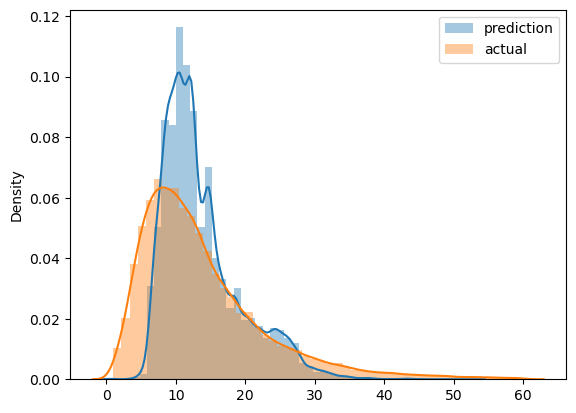

In [7]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [8]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [9]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-02.parquet')
len(df_train), len(df_val)

(65946, 62574)

In [10]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [11]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

6.034386403820207

In [12]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [14]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "olawale")
    
    mlflow.log_param("train-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet")
    mlflow.log_param("valid-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-02.parquet")
    
    alpha=0.001
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

In [16]:
!pip install xgboost hyperopt

  Using cached xgboost-2.0.3-py3-none-manylinux2014_x86_64.whl.metadata (2.0 kB)
  Using cached hyperopt-0.2.7-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached py4j-0.10.9.7-py2.py3-none-any.whl.metadata (1.5 kB)
Using cached xgboost-2.0.3-py3-none-manylinux2014_x86_64.whl (297.1 MB)
Using cached hyperopt-0.2.7-py2.py3-none-any.whl (1.6 MB)
Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)


In [17]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [18]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [19]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [20]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:38:20] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.99706                           
[1]	validation-rmse:8.69430                           
[2]	validation-rmse:8.41260                           
[3]	validation-rmse:8.15062                           
[4]	validation-rmse:7.90733                           
[5]	validation-rmse:7.68180                           
[6]	validation-rmse:7.47300                           
[7]	validation-rmse:7.28033                           
[8]	validation-rmse:7.10216                           
[9]	validation-rmse:6.93780                           
[10]	validation-rmse:6.78665                          
[11]	validation-rmse:6.64767                          
[12]	validation-rmse:6.52005                          
[13]	validation-rmse:6.40304                          
[14]	validation-rmse:6.29553                          
[15]	validation-rmse:6.19714                          
[16]	validation-rmse:6.10716                          
[17]	validation-rmse:6.02459                          
[18]	valid

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:40:27] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.54127                                                       
[1]	validation-rmse:6.47915                                                       
[2]	validation-rmse:5.87907                                                       
[3]	validation-rmse:5.55411                                                       
[4]	validation-rmse:5.37889                                                       
[5]	validation-rmse:5.29161                                                       
[6]	validation-rmse:5.23463                                                       
[7]	validation-rmse:5.20644                                                       
[8]	validation-rmse:5.19048                                                       
[9]	validation-rmse:5.17934                                                       
[10]	validation-rmse:5.17128                                                      
[11]	validation-rmse:5.16449                                                      
[12]

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:40:45] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.42513                                                    
[1]	validation-rmse:5.67548                                                    
[2]	validation-rmse:5.49694                                                    
[3]	validation-rmse:5.42733                                                    
[4]	validation-rmse:5.39280                                                    
[5]	validation-rmse:5.37637                                                    
[6]	validation-rmse:5.35187                                                    
[7]	validation-rmse:5.34333                                                    
[8]	validation-rmse:5.34024                                                    
[9]	validation-rmse:5.33389                                                    
[10]	validation-rmse:5.33262                                                   
[11]	validation-rmse:5.33021                                                   
[12]	validation-rmse:5.32872            

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:41:05] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.79830                                                    
[1]	validation-rmse:8.33665                                                    
[2]	validation-rmse:7.93121                                                    
[3]	validation-rmse:7.57605                                                    
[4]	validation-rmse:7.26641                                                    
[5]	validation-rmse:6.99747                                                    
[6]	validation-rmse:6.76426                                                    
[7]	validation-rmse:6.56344                                                    
[8]	validation-rmse:6.39054                                                    
[9]	validation-rmse:6.24195                                                    
[10]	validation-rmse:6.11483                                                   
[11]	validation-rmse:6.00676                                                   
[12]	validation-rmse:5.91445            

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:42:32] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:6.16365                                                    
[2]	validation-rmse:5.70386                                                    
[3]	validation-rmse:5.49496                                                    
[4]	validation-rmse:5.39762                                                    
[5]	validation-rmse:5.35225                                                    
[6]	validation-rmse:5.32140                                                    
[7]	validation-rmse:5.30469                                                    
[8]	validation-rmse:5.29670                                                    
[9]	validation-rmse:5.28585                                                    
[10]	validation-rmse:5.28121                                                   
[11]	validation-rmse:5.27742                                                   
[12]	validation-rmse:5.27006                                                   
[13]	validation-rmse:5.26842            

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:42:46] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.11782                                                    
[1]	validation-rmse:6.03055                                                    
[2]	validation-rmse:5.54378                                                    
[3]	validation-rmse:5.33329                                                    
[4]	validation-rmse:5.24486                                                    
[5]	validation-rmse:5.20808                                                    
[6]	validation-rmse:5.19073                                                    
[7]	validation-rmse:5.18122                                                    
[8]	validation-rmse:5.17608                                                    
[9]	validation-rmse:5.17159                                                    
[10]	validation-rmse:5.17129                                                   
[11]	validation-rmse:5.16884                                                   
[12]	validation-rmse:5.16630            

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:43:02] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.86445                                                    
[1]	validation-rmse:8.45280                                                    
[2]	validation-rmse:8.08322                                                    
[3]	validation-rmse:7.75167                                                    
[4]	validation-rmse:7.45592                                                    
[5]	validation-rmse:7.19260                                                    
[6]	validation-rmse:6.95886                                                    
[7]	validation-rmse:6.75168                                                    
[8]	validation-rmse:6.56843                                                    
[9]	validation-rmse:6.40735                                                    
[10]	validation-rmse:6.26586                                                   
[11]	validation-rmse:6.14230                                                   
[12]	validation-rmse:6.03358            

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:44:33] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.66664                                                    
[1]	validation-rmse:5.24952                                                    
[2]	validation-rmse:5.20928                                                    
[3]	validation-rmse:5.20955                                                    
[4]	validation-rmse:5.20777                                                    
[5]	validation-rmse:5.20350                                                    
[6]	validation-rmse:5.20254                                                    
[7]	validation-rmse:5.20137                                                    
[8]	validation-rmse:5.19461                                                    
[9]	validation-rmse:5.19377                                                    
[10]	validation-rmse:5.19082                                                   
[11]	validation-rmse:5.19320                                                   
[12]	validation-rmse:5.18816            

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:44:45] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:5.41024                                                    
[5]	validation-rmse:5.39060                                                    
[6]	validation-rmse:5.38206                                                    
[7]	validation-rmse:5.37616                                                    
[8]	validation-rmse:5.36624                                                    
[9]	validation-rmse:5.36282                                                    
[10]	validation-rmse:5.35632                                                   
[11]	validation-rmse:5.35205                                                   
[12]	validation-rmse:5.34783                                                   
[13]	validation-rmse:5.34562                                                   
[14]	validation-rmse:5.34253                                                   
[15]	validation-rmse:5.33804                                                   
[16]	validation-rmse:5.33042            

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:44:59] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.92705                                                    
[1]	validation-rmse:6.98678                                                    
[2]	validation-rmse:6.37481                                                    
[3]	validation-rmse:5.98273                                                    
[4]	validation-rmse:5.73744                                                    
[5]	validation-rmse:5.58502                                                    
[6]	validation-rmse:5.48920                                                    
[7]	validation-rmse:5.42716                                                    
[8]	validation-rmse:5.38589                                                    
[9]	validation-rmse:5.35743                                                    
[10]	validation-rmse:5.33747                                                   
[11]	validation-rmse:5.32282                                                   
[12]	validation-rmse:5.31267            

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:45:28] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.46833                                                     
[1]	validation-rmse:5.24365                                                     
[2]	validation-rmse:5.21201                                                     
[3]	validation-rmse:5.21749                                                     
[4]	validation-rmse:5.22079                                                     
[5]	validation-rmse:5.22157                                                     
[6]	validation-rmse:5.22408                                                     
[7]	validation-rmse:5.22377                                                     
[8]	validation-rmse:5.22294                                                     
[9]	validation-rmse:5.22167                                                     
[10]	validation-rmse:5.22252                                                    
[11]	validation-rmse:5.21901                                                    
[12]	validation-rmse:5.22304

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:45:39] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.54887                                                     
[2]	validation-rmse:6.96963                                                     
[3]	validation-rmse:6.53875                                                     
[4]	validation-rmse:6.21773                                                     
[5]	validation-rmse:5.98629                                                     
[6]	validation-rmse:5.81694                                                     
[7]	validation-rmse:5.69172                                                     
[8]	validation-rmse:5.60452                                                     
[9]	validation-rmse:5.53747                                                     
[10]	validation-rmse:5.49426                                                    
[11]	validation-rmse:5.45509                                                    
[12]	validation-rmse:5.43188                                                    
[13]	validation-rmse:5.41007

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:46:03] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[6]	validation-rmse:5.48713                                                     
[7]	validation-rmse:5.48290                                                     
[8]	validation-rmse:5.48120                                                     
[9]	validation-rmse:5.47980                                                     
[10]	validation-rmse:5.47417                                                    
[11]	validation-rmse:5.46491                                                    
[12]	validation-rmse:5.46048                                                    
[13]	validation-rmse:5.46036                                                    
[14]	validation-rmse:5.45814                                                    
[15]	validation-rmse:5.44842                                                    
[16]	validation-rmse:5.44676                                                    
[17]	validation-rmse:5.43853                                                    
[18]	validation-rmse:5.43065

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:46:10] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.89402                                                     
[1]	validation-rmse:5.45124                                                     
[2]	validation-rmse:5.35488                                                     
[3]	validation-rmse:5.32155                                                     
[4]	validation-rmse:5.30386                                                     
[5]	validation-rmse:5.28444                                                     
[6]	validation-rmse:5.27963                                                     
[7]	validation-rmse:5.27737                                                     
[8]	validation-rmse:5.27637                                                     
[9]	validation-rmse:5.26890                                                     
[10]	validation-rmse:5.26734                                                    
[11]	validation-rmse:5.26477                                                    
[12]	validation-rmse:5.26383

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:46:24] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.79223                                                     
[1]	validation-rmse:5.77099                                                     
[2]	validation-rmse:5.40146                                                     
[3]	validation-rmse:5.27386                                                     
[4]	validation-rmse:5.22577                                                     
[5]	validation-rmse:5.20932                                                     
[6]	validation-rmse:5.19595                                                     
[7]	validation-rmse:5.19238                                                     
[8]	validation-rmse:5.18774                                                     
[9]	validation-rmse:5.18727                                                     
[10]	validation-rmse:5.18503                                                    
[11]	validation-rmse:5.17919                                                    
[12]	validation-rmse:5.17157

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:46:44] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.87032                                                     
[1]	validation-rmse:6.90278                                                     
[2]	validation-rmse:6.29840                                                     
[3]	validation-rmse:5.91032                                                     
[4]	validation-rmse:5.68681                                                     
[5]	validation-rmse:5.52545                                                     
[6]	validation-rmse:5.44241                                                     
[7]	validation-rmse:5.39133                                                     
[8]	validation-rmse:5.34203                                                     
[9]	validation-rmse:5.32645                                                     
[10]	validation-rmse:5.31536                                                    
[11]	validation-rmse:5.29391                                                    
[12]	validation-rmse:5.29001

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:47:08] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.76290                                                     
[1]	validation-rmse:5.29008                                                     
[2]	validation-rmse:5.22463                                                     
[3]	validation-rmse:5.20558                                                     
[4]	validation-rmse:5.20640                                                     
[5]	validation-rmse:5.20341                                                     
[6]	validation-rmse:5.19774                                                     
[7]	validation-rmse:5.19444                                                     
[8]	validation-rmse:5.19304                                                     
[9]	validation-rmse:5.18938                                                     
[10]	validation-rmse:5.18731                                                    
[11]	validation-rmse:5.18628                                                    
[12]	validation-rmse:5.18769

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:47:15] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.86911                                                     
[1]	validation-rmse:5.31135                                                     
[2]	validation-rmse:5.22543                                                     
[3]	validation-rmse:5.21241                                                     
[4]	validation-rmse:5.20550                                                     
[5]	validation-rmse:5.19976                                                     
[6]	validation-rmse:5.19405                                                     
[7]	validation-rmse:5.19185                                                     
[8]	validation-rmse:5.18966                                                     
[9]	validation-rmse:5.18392                                                     
[10]	validation-rmse:5.18133                                                    
[11]	validation-rmse:5.17587                                                    
[12]	validation-rmse:5.17500

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:47:27] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.43585                                                     
[2]	validation-rmse:6.84215                                                     
[3]	validation-rmse:6.41236                                                     
[4]	validation-rmse:6.10521                                                     
[5]	validation-rmse:5.88672                                                     
[6]	validation-rmse:5.73426                                                     
[7]	validation-rmse:5.62596                                                     
[8]	validation-rmse:5.54906                                                     
[9]	validation-rmse:5.49282                                                     
[10]	validation-rmse:5.45188                                                    
[11]	validation-rmse:5.42391                                                    
[12]	validation-rmse:5.40254                                                    
[13]	validation-rmse:5.38722

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:48:12] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.95798                                                     
[1]	validation-rmse:8.62200                                                     
[2]	validation-rmse:8.31248                                                     
[3]	validation-rmse:8.02756                                                     
[4]	validation-rmse:7.76643                                                     
[5]	validation-rmse:7.52688                                                     
[6]	validation-rmse:7.30743                                                     
[7]	validation-rmse:7.10695                                                     
[8]	validation-rmse:6.92433                                                     
[9]	validation-rmse:6.75823                                                     
[10]	validation-rmse:6.60715                                                    
[11]	validation-rmse:6.46984                                                    
[12]	validation-rmse:6.34529

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:49:48] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.45492                                                     
[1]	validation-rmse:7.75397                                                     
[2]	validation-rmse:7.19484                                                     
[3]	validation-rmse:6.75260                                                     
[4]	validation-rmse:6.40738                                                     
[5]	validation-rmse:6.13893                                                     
[6]	validation-rmse:5.93138                                                     
[7]	validation-rmse:5.77118                                                     
[8]	validation-rmse:5.64826                                                     
[9]	validation-rmse:5.55416                                                     
[10]	validation-rmse:5.48167                                                    
[11]	validation-rmse:5.42351                                                    
[12]	validation-rmse:5.38020

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:50:18] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.61086                                                     
[1]	validation-rmse:8.01074                                                     
[2]	validation-rmse:7.51059                                                     
[3]	validation-rmse:7.09350                                                     
[4]	validation-rmse:6.74869                                                     
[5]	validation-rmse:6.46593                                                     
[6]	validation-rmse:6.23457                                                     
[7]	validation-rmse:6.04625                                                     
[8]	validation-rmse:5.89368                                                     
[9]	validation-rmse:5.76973                                                     
[10]	validation-rmse:5.67049                                                    
[11]	validation-rmse:5.58945                                                    
[12]	validation-rmse:5.52314

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:50:48] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.49934                                                     
[1]	validation-rmse:7.82640                                                     
[2]	validation-rmse:7.28392                                                     
[3]	validation-rmse:6.84764                                                     
[4]	validation-rmse:6.50057                                                     
[5]	validation-rmse:6.22672                                                     
[6]	validation-rmse:6.01201                                                     
[7]	validation-rmse:5.84295                                                     
[8]	validation-rmse:5.71224                                                     
[9]	validation-rmse:5.60958                                                     
[10]	validation-rmse:5.52942                                                    
[11]	validation-rmse:5.46576                                                    
[12]	validation-rmse:5.41607

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:51:26] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.71910                                                     
[1]	validation-rmse:8.19659                                                     
[2]	validation-rmse:7.74616                                                     
[3]	validation-rmse:7.35902                                                     
[4]	validation-rmse:7.02943                                                     
[5]	validation-rmse:6.74789                                                     
[6]	validation-rmse:6.51010                                                     
[7]	validation-rmse:6.30936                                                     
[8]	validation-rmse:6.14000                                                     
[9]	validation-rmse:5.99770                                                     
[10]	validation-rmse:5.87820                                                    
[11]	validation-rmse:5.77944                                                    
[12]	validation-rmse:5.69566

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:52:05] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[8]	validation-rmse:6.05254                                                     
[9]	validation-rmse:5.95783                                                     
[10]	validation-rmse:5.88584                                                    
[11]	validation-rmse:5.82628                                                    
[12]	validation-rmse:5.78052                                                    
[13]	validation-rmse:5.74314                                                    
[14]	validation-rmse:5.71261                                                    
[15]	validation-rmse:5.68837                                                    
[16]	validation-rmse:5.66888                                                    
[17]	validation-rmse:5.65461                                                    
[18]	validation-rmse:5.63907                                                    
[19]	validation-rmse:5.62754                                                    
[20]	validation-rmse:5.61928

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:52:29] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:5.76060                                                     
[2]	validation-rmse:5.52888                                                     
[3]	validation-rmse:5.44213                                                     
[4]	validation-rmse:5.40442                                                     
[5]	validation-rmse:5.37895                                                     
[6]	validation-rmse:5.36049                                                     
[7]	validation-rmse:5.34653                                                     
[8]	validation-rmse:5.34091                                                     
[9]	validation-rmse:5.33507                                                     
[10]	validation-rmse:5.33254                                                    
[11]	validation-rmse:5.33037                                                    
[12]	validation-rmse:5.32591                                                    
[13]	validation-rmse:5.32494

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:52:50] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:5.84919                                                     
[4]	validation-rmse:5.66437                                                     
[5]	validation-rmse:5.55501                                                     
[6]	validation-rmse:5.48902                                                     
[7]	validation-rmse:5.44638                                                     
[8]	validation-rmse:5.42090                                                     
[9]	validation-rmse:5.39874                                                     
[10]	validation-rmse:5.38725                                                    
[11]	validation-rmse:5.37774                                                    
[12]	validation-rmse:5.37208                                                    
[13]	validation-rmse:5.37007                                                    
[14]	validation-rmse:5.36488                                                    
[15]	validation-rmse:5.36136

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:53:14] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.56368                                                     
[1]	validation-rmse:6.54382                                                     
[2]	validation-rmse:5.96506                                                     
[3]	validation-rmse:5.65296                                                     
[4]	validation-rmse:5.47838                                                     
[5]	validation-rmse:5.38738                                                     
[6]	validation-rmse:5.32941                                                     
[7]	validation-rmse:5.29391                                                     
[8]	validation-rmse:5.27287                                                     
[9]	validation-rmse:5.25971                                                     
[10]	validation-rmse:5.25191                                                    
[11]	validation-rmse:5.24730                                                    
[12]	validation-rmse:5.24506

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:53:29] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.97780                                                     
[1]	validation-rmse:8.65875                                                     
[2]	validation-rmse:8.36389                                                     
[3]	validation-rmse:8.09161                                                     
[4]	validation-rmse:7.84031                                                     
[5]	validation-rmse:7.60946                                                     
[6]	validation-rmse:7.39706                                                     
[7]	validation-rmse:7.20192                                                     
[8]	validation-rmse:7.02277                                                     
[9]	validation-rmse:6.85880                                                     
[10]	validation-rmse:6.70922                                                    
[11]	validation-rmse:6.57233                                                    
[12]	validation-rmse:6.44774

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:54:55] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.97148                                                     
[1]	validation-rmse:8.64688                                                     
[2]	validation-rmse:8.34683                                                     
[3]	validation-rmse:8.06930                                                     
[4]	validation-rmse:7.81346                                                     
[5]	validation-rmse:7.57824                                                     
[6]	validation-rmse:7.36212                                                     
[7]	validation-rmse:7.16358                                                     
[8]	validation-rmse:6.98187                                                     
[9]	validation-rmse:6.81565                                                     
[10]	validation-rmse:6.66372                                                    
[11]	validation-rmse:6.52521                                                    
[12]	validation-rmse:6.39875

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:56:33] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.21392                                                     
[1]	validation-rmse:7.37795                                                     
[2]	validation-rmse:6.75816                                                     
[3]	validation-rmse:6.30832                                                     
[4]	validation-rmse:5.98159                                                     
[5]	validation-rmse:5.75117                                                     
[6]	validation-rmse:5.58756                                                     
[7]	validation-rmse:5.47454                                                     
[8]	validation-rmse:5.39035                                                     
[9]	validation-rmse:5.33308                                                     
[10]	validation-rmse:5.29196                                                    
[11]	validation-rmse:5.26501                                                    
[12]	validation-rmse:5.24017

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:56:55] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.59558                                                     
[1]	validation-rmse:6.55634                                                     
[2]	validation-rmse:5.95840                                                     
[3]	validation-rmse:5.61724                                                     
[4]	validation-rmse:5.43805                                                     
[5]	validation-rmse:5.33292                                                     
[6]	validation-rmse:5.27226                                                     
[7]	validation-rmse:5.23714                                                     
[8]	validation-rmse:5.21457                                                     
[9]	validation-rmse:5.20045                                                     
[10]	validation-rmse:5.19035                                                    
[11]	validation-rmse:5.18536                                                    
[12]	validation-rmse:5.18136

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:57:10] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.88306                                                     
[1]	validation-rmse:8.48758                                                     
[2]	validation-rmse:8.13151                                                     
[3]	validation-rmse:7.81027                                                     
[4]	validation-rmse:7.52536                                                     
[5]	validation-rmse:7.26824                                                     
[6]	validation-rmse:7.04158                                                     
[7]	validation-rmse:6.83701                                                     
[8]	validation-rmse:6.65720                                                     
[9]	validation-rmse:6.49338                                                     
[10]	validation-rmse:6.35115                                                    
[11]	validation-rmse:6.22678                                                    
[12]	validation-rmse:6.11648

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:58:07] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:7.22776                                                     
[2]	validation-rmse:6.62706                                                     
[3]	validation-rmse:6.21954                                                     
[4]	validation-rmse:5.95395                                                     
[5]	validation-rmse:5.76783                                                     
[6]	validation-rmse:5.64902                                                     
[7]	validation-rmse:5.56197                                                     
[8]	validation-rmse:5.50708                                                     
[9]	validation-rmse:5.47128                                                     
[10]	validation-rmse:5.44199                                                    
[11]	validation-rmse:5.42786                                                    
[12]	validation-rmse:5.41647                                                    
[13]	validation-rmse:5.40592

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:58:26] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.29355                                                     
[1]	validation-rmse:6.22053                                                     
[2]	validation-rmse:5.68845                                                     
[3]	validation-rmse:5.42814                                                     
[4]	validation-rmse:5.30460                                                     
[5]	validation-rmse:5.24143                                                     
[6]	validation-rmse:5.21161                                                     
[7]	validation-rmse:5.19391                                                     
[8]	validation-rmse:5.18701                                                     
[9]	validation-rmse:5.18064                                                     
[10]	validation-rmse:5.17891                                                    
[11]	validation-rmse:5.17299                                                    
[12]	validation-rmse:5.17229

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [18:58:40] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.28771                                                     
[2]	validation-rmse:7.86877                                                     
[3]	validation-rmse:7.50628                                                     
[4]	validation-rmse:7.19368                                                     
[5]	validation-rmse:6.92543                                                     
[6]	validation-rmse:6.69600                                                     
[7]	validation-rmse:6.50031                                                     
[8]	validation-rmse:6.33428                                                     
[9]	validation-rmse:6.19328                                                     
[10]	validation-rmse:6.07422                                                    
[11]	validation-rmse:5.97393                                                    
[12]	validation-rmse:5.88941                                                    
[13]	validation-rmse:5.81880

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:00:31] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[6]	validation-rmse:5.54482                                                     
[7]	validation-rmse:5.53611                                                     
[8]	validation-rmse:5.53039                                                     
[9]	validation-rmse:5.52402                                                     
[10]	validation-rmse:5.52049                                                    
[11]	validation-rmse:5.51470                                                    
[12]	validation-rmse:5.50956                                                    
[13]	validation-rmse:5.50508                                                    
[14]	validation-rmse:5.50154                                                    
[15]	validation-rmse:5.49640                                                    
[16]	validation-rmse:5.49153                                                    
[17]	validation-rmse:5.48723                                                    
[18]	validation-rmse:5.48373

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:00:55] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.89767                                                     
[1]	validation-rmse:8.51296                                                     
[2]	validation-rmse:8.16548                                                     
[3]	validation-rmse:7.85225                                                     
[4]	validation-rmse:7.57058                                                     
[5]	validation-rmse:7.31767                                                     
[6]	validation-rmse:7.09142                                                     
[7]	validation-rmse:6.88929                                                     
[8]	validation-rmse:6.70928                                                     
[9]	validation-rmse:6.54928                                                     
[10]	validation-rmse:6.40687                                                    
[11]	validation-rmse:6.28015                                                    
[12]	validation-rmse:6.16827

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:02:45] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.51569                                                     
[1]	validation-rmse:6.47354                                                     
[2]	validation-rmse:5.90137                                                     
[3]	validation-rmse:5.60061                                                     
[4]	validation-rmse:5.43681                                                     
[5]	validation-rmse:5.34596                                                     
[6]	validation-rmse:5.29391                                                     
[7]	validation-rmse:5.26147                                                     
[8]	validation-rmse:5.24516                                                     
[9]	validation-rmse:5.23468                                                     
[10]	validation-rmse:5.22292                                                    
[11]	validation-rmse:5.21773                                                    
[12]	validation-rmse:5.21375

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:02:59] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:5.39667                                                     
[4]	validation-rmse:5.38898                                                     
[5]	validation-rmse:5.37887                                                     
[6]	validation-rmse:5.37169                                                     
[7]	validation-rmse:5.37005                                                     
[8]	validation-rmse:5.36411                                                     
[9]	validation-rmse:5.35339                                                     
[10]	validation-rmse:5.31243                                                    
[11]	validation-rmse:5.30674                                                    
[12]	validation-rmse:5.30078                                                    
[13]	validation-rmse:5.29702                                                    
[14]	validation-rmse:5.29104                                                    
[15]	validation-rmse:5.27596

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:03:10] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.32222                                                     
[1]	validation-rmse:7.53998                                                     
[2]	validation-rmse:6.93541                                                     
[3]	validation-rmse:6.47465                                                     
[4]	validation-rmse:6.13029                                                     
[5]	validation-rmse:5.87340                                                     
[6]	validation-rmse:5.68518                                                     
[7]	validation-rmse:5.54836                                                     
[8]	validation-rmse:5.44553                                                     
[9]	validation-rmse:5.37373                                                     
[10]	validation-rmse:5.31900                                                    
[11]	validation-rmse:5.28133                                                    
[12]	validation-rmse:5.25241

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:03:48] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:6.56612                                                     
[3]	validation-rmse:6.16392                                                     
[4]	validation-rmse:5.89956                                                     
[5]	validation-rmse:5.72888                                                     
[6]	validation-rmse:5.61256                                                     
[7]	validation-rmse:5.53725                                                     
[8]	validation-rmse:5.48406                                                     
[9]	validation-rmse:5.44276                                                     
[10]	validation-rmse:5.41455                                                    
[11]	validation-rmse:5.39624                                                    
[12]	validation-rmse:5.38403                                                    
[13]	validation-rmse:5.37288                                                    
[14]	validation-rmse:5.36453

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:04:20] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:6.83659                                                     
[2]	validation-rmse:6.24999                                                     
[3]	validation-rmse:5.89438                                                     
[4]	validation-rmse:5.68101                                                     
[5]	validation-rmse:5.55600                                                     
[6]	validation-rmse:5.47880                                                     
[7]	validation-rmse:5.42266                                                     
[8]	validation-rmse:5.38894                                                     
[9]	validation-rmse:5.36220                                                     
[10]	validation-rmse:5.34787                                                    
[11]	validation-rmse:5.33770                                                    
[12]	validation-rmse:5.32998                                                    
[13]	validation-rmse:5.32375

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:04:50] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[5]	validation-rmse:5.82730                                                     
[6]	validation-rmse:5.71018                                                     
[7]	validation-rmse:5.63511                                                     
[8]	validation-rmse:5.58188                                                     
[9]	validation-rmse:5.54759                                                     
[10]	validation-rmse:5.52629                                                    
[11]	validation-rmse:5.51098                                                    
[12]	validation-rmse:5.49914                                                    
[13]	validation-rmse:5.49065                                                    
[14]	validation-rmse:5.48267                                                    
[15]	validation-rmse:5.47167                                                    
[16]	validation-rmse:5.46838                                                    
[17]	validation-rmse:5.46467

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:05:18] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.28968                                                     
[1]	validation-rmse:6.26015                                                     
[2]	validation-rmse:5.77526                                                     
[3]	validation-rmse:5.55348                                                     
[4]	validation-rmse:5.44898                                                     
[5]	validation-rmse:5.39074                                                     
[6]	validation-rmse:5.36318                                                     
[7]	validation-rmse:5.34862                                                     
[8]	validation-rmse:5.34253                                                     
[9]	validation-rmse:5.33722                                                     
[10]	validation-rmse:5.33532                                                    
[11]	validation-rmse:5.33164                                                    
[12]	validation-rmse:5.33009

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:05:29] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:5.98802                                                     
[2]	validation-rmse:5.61891                                                     
[3]	validation-rmse:5.47195                                                     
[4]	validation-rmse:5.40086                                                     
[5]	validation-rmse:5.36784                                                     
[6]	validation-rmse:5.34314                                                     
[7]	validation-rmse:5.33727                                                     
[8]	validation-rmse:5.33179                                                     
[9]	validation-rmse:5.32721                                                     
[10]	validation-rmse:5.32351                                                    
[11]	validation-rmse:5.32111                                                    
[12]	validation-rmse:5.31740                                                    
[13]	validation-rmse:5.31443

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:05:40] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.13577                                                     
[1]	validation-rmse:7.27575                                                     
[2]	validation-rmse:6.66609                                                     
[3]	validation-rmse:6.24227                                                     
[4]	validation-rmse:5.94968                                                     
[5]	validation-rmse:5.75155                                                     
[6]	validation-rmse:5.61574                                                     
[7]	validation-rmse:5.52275                                                     
[8]	validation-rmse:5.45960                                                     
[9]	validation-rmse:5.41510                                                     
[10]	validation-rmse:5.38322                                                    
[11]	validation-rmse:5.36147                                                    
[12]	validation-rmse:5.34574

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:06:11] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.24057                                                     
[1]	validation-rmse:5.56805                                                     
[2]	validation-rmse:5.41652                                                     
[3]	validation-rmse:5.37830                                                     
[4]	validation-rmse:5.36095                                                     
[5]	validation-rmse:5.35114                                                     
[6]	validation-rmse:5.34532                                                     
[7]	validation-rmse:5.33923                                                     
[8]	validation-rmse:5.33428                                                     
[9]	validation-rmse:5.32996                                                     
[10]	validation-rmse:5.32343                                                    
[11]	validation-rmse:5.31995                                                    
[12]	validation-rmse:5.31678

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:06:21] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:6.02501                                                     
[4]	validation-rmse:5.79850                                                     
[5]	validation-rmse:5.65999                                                     
[6]	validation-rmse:5.57292                                                     
[7]	validation-rmse:5.51624                                                     
[8]	validation-rmse:5.47937                                                     
[9]	validation-rmse:5.45544                                                     
[10]	validation-rmse:5.44112                                                    
[11]	validation-rmse:5.43004                                                    
[12]	validation-rmse:5.42245                                                    
[13]	validation-rmse:5.41856                                                    
[14]	validation-rmse:5.41537                                                    
[15]	validation-rmse:5.41378

/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:06:44] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.62307                                                     
[1]	validation-rmse:8.03040                                                     
[2]	validation-rmse:7.53131                                                     
[3]	validation-rmse:7.11590                                                     
[4]	validation-rmse:6.76712                                                     
[5]	validation-rmse:6.48190                                                     
[6]	validation-rmse:6.24532                                                     
[7]	validation-rmse:6.05427                                                     
[8]	validation-rmse:5.89427                                                     
[9]	validation-rmse:5.76532                                                     
[10]	validation-rmse:5.65848                                                    
[11]	validation-rmse:5.57172                                                    
[12]	validation-rmse:5.50251

In [21]:

params = {
    'learning_rate':     0.22182745164887246,
    'max_depth':         11,
    'min_child_weight':  4.602883869360774,
    'objective':         'reg:linear',
    'reg_alpha':         0.08867038296596122,
    'reg_lambda':        0.03708483076104513,
    'seed':                42
}

mlflow.xgboost.autolog()

booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, 'validation')],
    early_stopping_rounds=50
)

2024/05/21 19:44:39 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'aa49fb5b2e034e7cb29d472e6d10315b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[0]	validation-rmse:8.05164
[1]	validation-rmse:7.16757


/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:44:41] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[2]	validation-rmse:6.56612
[3]	validation-rmse:6.16392
[4]	validation-rmse:5.89956
[5]	validation-rmse:5.72888
[6]	validation-rmse:5.61256
[7]	validation-rmse:5.53725
[8]	validation-rmse:5.48406
[9]	validation-rmse:5.44276
[10]	validation-rmse:5.41455
[11]	validation-rmse:5.39624
[12]	validation-rmse:5.38403
[13]	validation-rmse:5.37288
[14]	validation-rmse:5.36453
[15]	validation-rmse:5.35802
[16]	validation-rmse:5.35326
[17]	validation-rmse:5.35129
[18]	validation-rmse:5.34814
[19]	validation-rmse:5.33928
[20]	validation-rmse:5.33800
[21]	validation-rmse:5.33644
[22]	validation-rmse:5.33522
[23]	validation-rmse:5.33169
[24]	validation-rmse:5.32945
[25]	validation-rmse:5.32803
[26]	validation-rmse:5.32551
[27]	validation-rmse:5.32422
[28]	validation-rmse:5.32216
[29]	validation-rmse:5.32052
[30]	validation-rmse:5.31962
[31]	validation-rmse:5.31716
[32]	validation-rmse:5.31520
[33]	validation-rmse:5.31342
[34]	validation-rmse:5.31215
[35]	validation-rmse:5.30944
[36]	validation-rmse:5

2024/05/21 19:45:16 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/05/21 19:45:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codespace/anaconda3/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:45:16] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."
2024/05/21 19:45:20 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/codespace/anaconda3/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


In [23]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "olawale")
    
    mlflow.log_param("train-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet")
    mlflow.log_param("valid-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-02.parquet")
    
    alpha=0.001
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    
    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

In [ ]:

best_params = {
    'learning_rate':     0.22182745164887246,
    'max_depth':         11,
    'min_child_weight':  4.602883869360774,
    'objective':         'reg:linear',
    'reg_alpha':         0.08867038296596122,
    'reg_lambda':        0.03708483076104513,
    'seed':                42
}

mlflow.log_params(best_params)

booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, 'validation')],
    early_stopping_rounds=50
)

y_pred = booster.predict(valid)
rmse